# FATS


In [1]:
import pandas as pd
import numpy as np
import functools
import re
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import *
import pygal
from pygal.style import Style


Read all data

In [2]:
data_folder = "./data/"

In [3]:
france = pd.read_csv(data_folder + "france_data.csv", sep=',', dtype=object)

In [4]:
us = pd.read_csv(data_folder + "us_data.csv", sep=',', dtype=object)

Select the "dairy" data

In [5]:
dairy_words = ["dairy","milk","cream","cheese","yaourt","fromage","de lait","yog"]
non_dairy_words = ["dairy free","non dairy","dairy-free","milk chocolat","cheeseburger","bacon","sandwich", "pasta","macaroni",
                  "non-dairy"," pain ", "beurre", " cake "]

In [6]:
france_dairy = select_entries(france, dairy_words)
print("Diary related items in France before cleaning: " + str(france_dairy.shape[0]))
us_dairy = select_entries(us, dairy_words)
print("Diary related items in US before cleaning: " + str(us_dairy.shape[0]))


Diary related items in France before cleaning: 12735
Diary related items in US before cleaning: 26093


In [7]:
france_dairy = clean_categories(france_dairy, non_dairy_words)
print("Diary related items in France after cleaning: " + str(france_dairy.shape[0]))
us_dairy = clean_categories(us_dairy, non_dairy_words)
print("Diary related items in US after cleaning: " + str(us_dairy.shape[0]))

Diary related items in France after cleaning: 10982
Diary related items in US after cleaning: 22529


# Distribution in category

In [8]:
def create_distribution(df,categories):
    distribution = pd.DataFrame(columns=['tag','category','count'])
    for i in range(categories.shape[0]):
        tag = categories[i,0]
        category = categories[i,1]
        newRow = pd.DataFrame([[tag, category, select_entries(df,[tag]).shape[0]]], columns=['tag','category','count'])
        distribution = distribution.append(newRow)
        df = clean_categories(df, [tag])
    return distribution, df.shape[0], df

In [9]:
tags = np.matrix([['yaourt', "yogurt"], 
                  ["yogurt", "yogurt"],
                  ["yog", "yogurt"],
                  ["cheddar", "cheese"],
                  ["cheese", "cheese"],
                  ["fromage", "cheese"],
                  ["ice", "ice cream"],
                  ["cream", "cream"],
                  ["dessert", "dessert"],
                  ["milk", "milk"],
                ])

In [10]:
france_distri, leftovers , rest = create_distribution(france_dairy,tags)
france_distri_grouped = france_distri.groupby(['category']).sum().drop('tag', axis = 1)
france_distri_grouped['procent'] = france_distri_grouped['count'].apply(lambda x: x/france_distri_grouped['count'].sum())
france_distri_grouped['country'] = "France"

In [20]:
us_distri, leftovers , rest = create_distribution(us_dairy,tags)
us_distri_grouped = us_distri.groupby(['category']).sum().drop('tag', axis = 1)
us_distri_grouped['procent'] = us_distri_grouped['count'].apply(lambda x: x/us_distri_grouped['count'].sum())
us_distri_grouped['country'] = "US"

In [23]:
def getSubProcent(tag,category,distri):
    nr_with_tag = distri[distri['tag'] == tag]['count'][0]
    total_products = distri.sum()['count']
    return nr_with_tag / total_products * 100

In [24]:
us_distri_full= [{'value': us_distri_grouped['procent'][0],'label': 'Of which ' + "{0:.1f}".format(getSubProcent("cheddar","cheese",us_distri)) + '% is Cheddar'},
                 {'value': us_distri_grouped['procent'][1]},
                 {'value': us_distri_grouped['procent'][2]},
                 {'value': us_distri_grouped['procent'][3]},
                 {'value': us_distri_grouped['procent'][4]},
                 {'value': us_distri_grouped['procent'][5]},
                ]


In [26]:
bar_chart_distri = pygal.Bar()
bar_chart_distri.title = 'Distribution within dairy products'
bar_chart_distri.x_labels = list(us_distri_grouped.T)
bar_chart_distri.add('France', france_distri_grouped['procent'] , formatter=lambda y: "{0:.1f}%".format(y*100))
bar_chart_distri.add('US', us_distri_full, formatter=lambda y: "{0:.1f}%".format(y*100))
bar_chart_distri.render_to_file('dairy_distribution.svg')  

# Nutrition fats

In [26]:
france_interesting_fats = france_dairy[['fat_100g','saturated-fat_100g','monounsaturated-fat_100g',
'polyunsaturated-fat_100g']].astype(float).replace({0.0:np.nan})
us_interesting_fats = us_dairy[['fat_100g','saturated-fat_100g','monounsaturated-fat_100g',
'polyunsaturated-fat_100g']].astype(float).replace({0.0:np.nan})

In [20]:
def re_arange_for_boxplot(df,country):
    new_df = pd.DataFrame(columns=['Y','X','country'])
    column_names = list(df)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            fat_sort = column_names[j]
            value = df.iloc[i,j]
            newRow = pd.DataFrame([[value,fat_sort,country]],columns=['Y','X','country'])
            new_df = new_df.append(newRow)
        
    return new_df

In [27]:
data_boxplot = re_arange_for_boxplot(france_interesting_fats,"France").append(re_arange_for_boxplot(us_interesting_fats,"US"))

(0, 40)

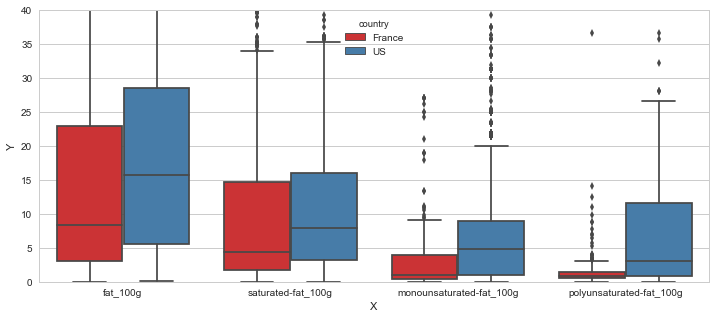

In [28]:
plt.figure(figsize=(12,5))
sns.set(style="whitegrid")
sns.boxplot(x="X",y ="Y", hue="country", data=data_boxplot, palette="Set1")
plt.ylim(0, 40)

# Nutrition sugar and protein

In [21]:
france_interesting_nutri = france_dairy[['sugars_100g','proteins_100g']].astype(float).replace({0.0:np.nan})
us_interesting_nutri = us_dairy[['sugars_100g','proteins_100g']].astype(float).replace({0.0:np.nan})

In [34]:
data_boxplot_other_nutri = re_arange_for_boxplot(france_interesting_nutri,"France").append(re_arange_for_boxplot(us_interesting_nutri,"US"))

(0, 40)

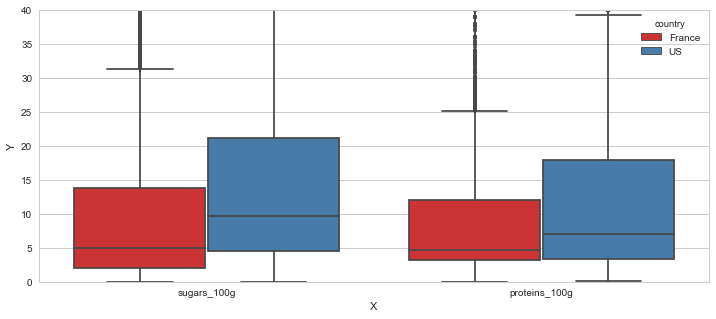

In [35]:
plt.figure(figsize=(12,5))
sns.set(style="whitegrid")
sns.boxplot(x="X",y ="Y", hue="country", data=data_boxplot_other_nutri, palette="Set1")
plt.ylim(0, 40)

# Pygal radar plot

In [28]:
france_interesting_nutri = france_dairy[['sugars_100g','proteins_100g','fat_100g','saturated-fat_100g','monounsaturated-fat_100g',
'polyunsaturated-fat_100g','carbohydrates_100g']].astype(float).replace({0.0:np.nan}).dropna().mean()
us_interesting_nutri = us_dairy[['sugars_100g','proteins_100g','fat_100g','saturated-fat_100g','monounsaturated-fat_100g',
'polyunsaturated-fat_100g','carbohydrates_100g']].astype(float).replace({0.0:np.nan}).dropna().mean()

In [29]:
custom_style = Style(
    background='transparent',
    #plot_background='transparent',
    #foreground='#53E89B',
    #foreground_strong='#53A0E8',
    #foreground_subtle='#630C0D',
    opacity='.6',
    opacity_hover='.9',
    #transition='400ms ease-in',
    colors=('#80ADD7', '#0ABDA0'),
    label_font_size = 20,
    title_font_size = 30,
    legend_font_size = 20,
)

In [30]:
radar_chart = pygal.Radar(fill = True, style=custom_style)
radar_chart.title = 'Percentage of daily recommendations'
radar_chart.x_labels = ['Sugars','Proteins','Fat','Saturated fat','Monounsaturated fat',
'Polyunsaturated fat','Carbohydrates']
radar_chart.add('Us', us_interesting_nutri, formatter=lambda y: "{0:.2f}%".format(y))
radar_chart.add('France', france_interesting_nutri, formatter=lambda y: "{0:.2f}%".format(y))
radar_chart.render_to_file('dairy_daily_recommended.svg')

# Minerals and vitamins

In [164]:
tags = ['sodium_100g','calcium_100g',]

france_interesting_small = france_dairy[tags].astype(float).replace({0.0:np.nan})
us_interesting_small = us_dairy[tags].astype(float).replace({0.0:np.nan})

Per day

In [177]:
daily_rec = [2.3,0.8]

In [178]:
custom_style = Style(
    background='transparent',
    #plot_background='transparent',
    #foreground='#53E89B',
    #foreground_strong='#53A0E8',
    #foreground_subtle='#630C0D',
    opacity='.6',
    opacity_hover='.9',
    #transition='400ms ease-in',
    colors=('#80ADD7', '#0ABDA0'),
    label_font_size = 20,
    title_font_size = 30,
    legend_font_size = 20,
)
radar_chart = pygal.Bar(fill = True, style=custom_style)
radar_chart.title = 'Nutrients in Dairy products'
radar_chart.x_labels = tags
radar_chart.add('Us', (us_interesting_small/daily_rec).mean(), formatter=lambda y: "{0:.3f}".format(y))
radar_chart.add('France', (france_interesting_small/daily_rec).mean(), formatter=lambda y: "{0:.3f}".format(y))
radar_chart.render_to_file('dairy_nutri_radar_small.svg')